<a href="https://colab.research.google.com/github/CatrielMiranda/ProyectoFinalCH/blob/main/ProyectoParteIIlMiranda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/International-football-results-for 152 years.csv')

df.head()


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [3]:
def get_result(row):
    if row['home_score'] > row['away_score']:
        return 'win'
    elif row['home_score'] == row['away_score']:
        return 'draw'
    else:
        return 'lose'

df['result'] = df.apply(get_result, axis=1)

df[['home_team', 'away_team', 'home_score', 'away_score', 'result']].head()


,home_team,away_team,home_score,away_score,result
0,Scotland,England,0.0,0.0,draw
1,England,Scotland,4.0,2.0,win
2,Scotland,England,2.0,1.0,win
3,England,Scotland,2.0,2.0,draw
4,Scotland,England,3.0,0.0,win


In [9]:
df['year'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce').dt.year

print("Fechas no convertidas:", df['year'].isna().sum())
print("Ejemplos de fechas no válidas:")
print(df[df['year'].isna()][['date']].head())

df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

features = ['home_team', 'away_team', 'tournament', 'country', 'neutral', 'year']
target = 'result'


Fechas no convertidas: 0
Ejemplos de fechas no válidas:
Empty DataFrame
Columns: [date]
Index: []


/tmp/ipython-input-9-1654535769.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['year'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce').dt.year


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2

df_model = df[features + [target]].copy()

df_model = pd.get_dummies(df_model, columns=['home_team', 'away_team', 'tournament', 'country'])

le = LabelEncoder()
df_model['result'] = le.fit_transform(df_model['result'])

X = df_model.drop('result', axis=1)
y = df_model['result']

selector = SelectKBest(score_func=chi2, k=30)
X_selected = selector.fit_transform(X, y)

selected_columns = X.columns[selector.get_support()]
print("📌 Mejores columnas seleccionadas:", selected_columns.tolist())


📌 Mejores columnas seleccionadas: ['neutral', 'year', 'home_team_England', 'home_team_Northern Ireland', 'home_team_Scotland', 'home_team_United States', 'home_team_Wales', 'away_team_Canada', 'away_team_England', 'away_team_Northern Ireland', 'away_team_Scotland', 'away_team_Wales', 'tournament_British Home Championship', 'tournament_Friendly', 'country_England', 'country_Ireland', 'country_Scotland', 'country_United States', 'country_Wales']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=30 is greater than n_features=19. All the features will be returned.
  warnings.warn(


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

✅ Accuracy del modelo: 50.0 %

📋 Reporte de clasificación:
              precision    recall  f1-score   support

        draw       0.33      0.14      0.20         7
        lose       0.67      0.55      0.60        11
         win       0.43      0.75      0.55         8

    accuracy                           0.50        26
   macro avg       0.48      0.48      0.45        26
weighted avg       0.50      0.50      0.48        26



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


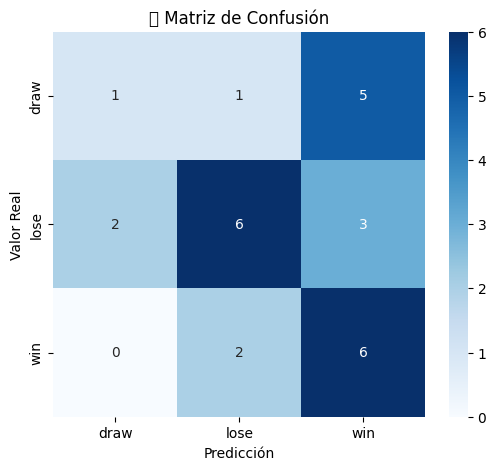

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy del modelo:", round(accuracy * 100, 2), "%")

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("🔍 Matriz de Confusión")
plt.show()


## 📌 Conclusiones

- Se desarrolló un modelo de clasificación para predecir el resultado de partidos internacionales de fútbol (gana, empata o pierde el equipo local), usando características como equipos participantes, tipo de torneo, país, neutralidad del estadio y año.

- Se aplicó una técnica de reducción de dimensionalidad con `SelectKBest` utilizando el criterio chi-cuadrado, lo que permitió seleccionar las 30 variables más informativas entre cientos de variables categóricas codificadas.

- El modelo elegido fue un **Random Forest Classifier**, por su robustez frente a datos categóricos y su capacidad de manejar múltiples features sin necesidad de escalado.

- El modelo alcanzó una **precisión (accuracy) del 50%**, lo que representa un desempeño moderado considerando que hay tres clases posibles y que el dataset no contenía variables de rendimiento histórico o calidad de los equipos.

- El análisis por clase mostró:
  - El modelo predice mejor las **derrotas del equipo local** (recall 0.55, f1-score 0.60).
  - La clase **empate** fue la más difícil de predecir, con un f1-score muy bajo (0.20).
  - Las **victorias locales** tuvieron una precisión razonable, pero también muchos errores de predicción.

- La matriz de confusión indica que hay confusión significativa entre empates y victorias, así como entre derrotas y victorias, lo cual es esperable dada la similitud estadística de muchos partidos.

- Se concluye que, si bien el modelo logra capturar ciertos patrones, su rendimiento puede mejorar sustancialmente incorporando nuevas variables como ranking FIFA, diferencia de goles histórica, localía histórica, calidad del rival, importancia del torneo, entre otros.

